# CIFAR 10 data set

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(train=True,
                                                  root='.',
                                                  download=True,
                                                  transform=transforms.ToTensor()
                                                  )

100%|██████████| 170498071/170498071 [00:04<00:00, 35182886.72it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(train=False,
                                                  root='.',
                                                  download=True,
                                                  transform=transforms.ToTensor()
                                                  )

Files already downloaded and verified


In [ ]:
print(train_dataset.classes)
K=len(train_dataset.classes)
print(K)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [ ]:
class CNN(nn.Module):
  def __init__(self,K):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(128*3*3,1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024,K)
    )
  def forward(self,x):
      x=self.conv_layers(x)
      x=x.view(x.size(0),-1)
      x=self.dense_layers(x)
      return x


In [ ]:
model=CNN(K)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 128
Train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           shuffle=True,
                                           batch_size=batch_size)

Test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           shuffle=False,
                                           batch_size=batch_size)

In [ ]:
n_epoch=15
train_losses=torch.zeros(n_epoch)
test_losses=torch.zeros(n_epoch)
for it in range(n_epoch):
  model.train()
  t0=datetime.now()
  train_loss=[]
  for input,target in Train_loader:
    input,target=input.to(device) , target.to(device)
    optimizer.zero_grad()
    outputs=model(input)
    error=loss_fn(outputs,target)
    error.backward()
    optimizer.step()
    train_loss.append(error.item())
  train_losses[it]=np.mean(train_loss)
  test_loss=[]
  for input,target in Test_loader:
    model.eval()
    with torch.inference_mode():
      input,target=input.to(device) , target.to(device)
      outputs=model(input)
      error=loss_fn(outputs,target)
      test_loss.append(error.item())
  test_losses[it]=np.mean(test_loss)
  dt=datetime.now()-t0
  print(f'Epoch {it+1}/{n_epoch} | Train Loss:{train_losses[it]:.2f} | Test Loss:{test_losses[it]:.2f} | Duration:{dt}')

Epoch 1/15 | Train Loss:1.71 | Test Loss:1.50 | Duration:0:00:11.615662
Epoch 2/15 | Train Loss:1.42 | Test Loss:1.33 | Duration:0:00:11.506538
Epoch 3/15 | Train Loss:1.29 | Test Loss:1.26 | Duration:0:00:11.311336
Epoch 4/15 | Train Loss:1.20 | Test Loss:1.20 | Duration:0:00:11.483563
Epoch 5/15 | Train Loss:1.13 | Test Loss:1.16 | Duration:0:00:11.338259
Epoch 6/15 | Train Loss:1.08 | Test Loss:1.11 | Duration:0:00:11.528710
Epoch 7/15 | Train Loss:1.03 | Test Loss:1.10 | Duration:0:00:11.477308
Epoch 8/15 | Train Loss:0.98 | Test Loss:1.08 | Duration:0:00:11.493266
Epoch 9/15 | Train Loss:0.94 | Test Loss:1.05 | Duration:0:00:11.592181
Epoch 10/15 | Train Loss:0.90 | Test Loss:1.04 | Duration:0:00:11.463602
Epoch 11/15 | Train Loss:0.87 | Test Loss:1.03 | Duration:0:00:11.593332
Epoch 12/15 | Train Loss:0.83 | Test Loss:1.04 | Duration:0:00:11.585137
Epoch 13/15 | Train Loss:0.81 | Test Loss:1.02 | Duration:0:00:11.590503
Epoch 14/15 | Train Loss:0.78 | Test Loss:1.04 | Duration:0:

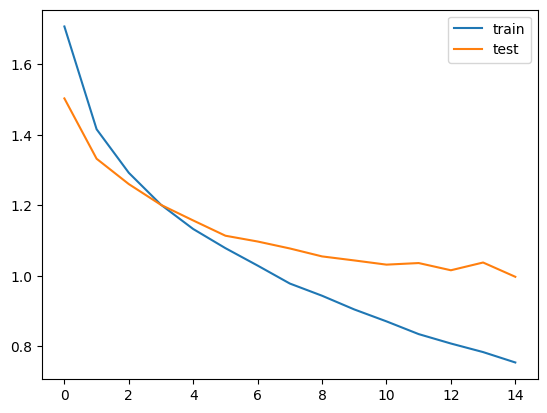

In [ ]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.inference_mode():
  n_correct=0
  n_total=0
  for inputs,targets in Train_loader:
    inputs,targets = inputs.to(device),targets.to(device)
    outputs = model(inputs)
    _,predection = torch.max(outputs,1)
    n_correct+=(predection == targets).sum().item()
    n_total+=targets.shape[0]
  train_acc = n_correct/n_total
print(train_acc)

0.8395


In [ ]:
model.eval()
with torch.inference_mode():
  n_correct=0
  n_total=0
  for inputs,targets in Test_loader:
    inputs,targets = inputs.to(device),targets.to(device)
    outputs = model(inputs)
    _,predection = torch.max(outputs,1)
    n_correct+=(predection == targets).sum().item()
    n_total+=targets.shape[0]
  test_acc = n_correct/n_total
print(test_acc)

0.7162


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
y_test = test_dataset.targets
p_test= np.array([])
for input , target in Test_loader:
  input,target = input.to(device) , target.to(device)
  output = model(input)
  _,perdictions = output.max(1)
  p_test = np.concatenate((p_test,perdictions.cpu().numpy()))

[[736  18  66  18  16  10  14  13  70  39]
 [ 16 815   8  11   1   2   9   5  18 115]
 [ 42   5 586  94  94  80  42  35  11  11]
 [ 14   9  58 548  57 196  41  51  11  15]
 [ 12   4  65  64 674  46  34  83  16   2]
 [ 11   4  35 171  51 632  24  58   9   5]
 [  5   6  38  77  71  28 758   8   6   3]
 [  8   1  19  34  61  51   4 810   2  10]
 [ 56  44  13  18   8   5   7  10 823  16]
 [ 30  81  12  26   6   6   5  25  29 780]]


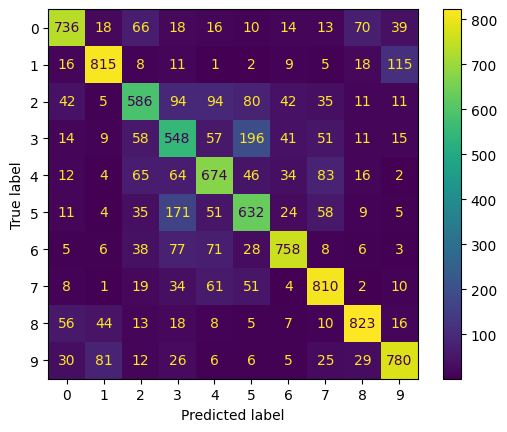

In [ ]:
cm = confusion_matrix(y_test, p_test, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()

print(cm)


In [ ]:
X_test=test_dataset.data
y_test=test_dataset.targets

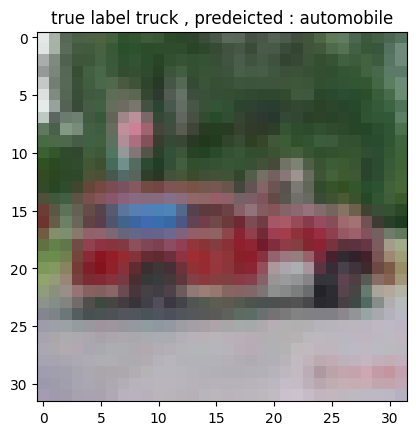

In [ ]:
Labels=train_dataset.classes
x_test = X_test
misMatch=np.where(y_test != p_test)[0]
index=np.random.choice(misMatch)
plt.imshow(x_test[index],cmap='gray')
plt.title(f'true label {Labels[y_test[index]]} , predeicted : {Labels[int(p_test[index])]}')
plt.show()

# Improved CIFAR 10

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
transformer_train = torchvision.transforms.Compose([
    #torchvision.transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
    transforms.RandomCrop(32,padding=4),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    #torchvision.transforms.RandomRotation(degrees=15),
    #torchvision.transforms.RandomPerspective(),
    transforms.ToTensor()
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(train=True,
                                                  root='.',
                                                  download=True,
                                                  transform=transformer_train
                                                  )

Files already downloaded and verified


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(train=False,
                                                  root='.',
                                                  download=True,
                                                  transform=transforms.ToTensor()
                                                  )

Files already downloaded and verified


In [ ]:
print(train_dataset.classes)
K=len(train_dataset.classes)
print(K)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [ ]:
class ImporvedCNN(nn.Module):
  def __init__(self,K):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )
    self.dense_layers = nn.Sequential(
        nn.Linear(128*4*4,1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024,K)
    )
  def forward(self,x):
      x=self.conv1(x)
      x=self.conv2(x)
      x=self.conv3(x)
      x=x.view(x.size(0),-1)
      x=self.dense_layers(x)
      return x


In [ ]:
Imporvedmodel=ImporvedCNN(K)

In [ ]:
# device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Imporvedmodel.to(device)

ImporvedCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128

In [ ]:
# batch,loss function, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Imporvedmodel.parameters())
batch_size = 128
Train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           shuffle=True,
                                           batch_size=batch_size)

Test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           shuffle=False,
                                           batch_size=batch_size)

In [ ]:
# training and test loop
n_epoch=15
train_losses=torch.zeros(n_epoch)
test_losses=torch.zeros(n_epoch)
for it in range(n_epoch):
  Imporvedmodel.train()
  t0=datetime.now()
  train_loss=[]
  for input,target in Train_loader:
    input,target=input.to(device) , target.to(device)
    optimizer.zero_grad()
    outputs=Imporvedmodel(input)
    error=loss_fn(outputs,target)
    error.backward()
    optimizer.step()
    train_loss.append(error.item())
  train_losses[it]=np.mean(train_loss)
  test_loss=[]
  for input,target in Test_loader:
    model.eval()
    with torch.inference_mode():
      input,target=input.to(device) , target.to(device)
      outputs=Imporvedmodel(input)
      error=loss_fn(outputs,target)
      test_loss.append(error.item())
  test_losses[it]=np.mean(test_loss)
  dt=datetime.now()-t0
  print(f'Epoch {it+1}/{n_epoch} | Train Loss:{train_losses[it]:.2f} | Test Loss:{test_losses[it]:.2f} | Duration:{dt}')

Epoch 1/15 | Train Loss:1.36 | Test Loss:1.00 | Duration:0:00:24.461738
Epoch 2/15 | Train Loss:0.88 | Test Loss:0.77 | Duration:0:00:24.371678
Epoch 3/15 | Train Loss:0.73 | Test Loss:0.70 | Duration:0:00:25.365758
Epoch 4/15 | Train Loss:0.63 | Test Loss:0.64 | Duration:0:00:24.243758
Epoch 5/15 | Train Loss:0.57 | Test Loss:0.58 | Duration:0:00:24.414051
Epoch 6/15 | Train Loss:0.52 | Test Loss:0.56 | Duration:0:00:24.511924
Epoch 7/15 | Train Loss:0.48 | Test Loss:0.55 | Duration:0:00:24.489515
Epoch 8/15 | Train Loss:0.45 | Test Loss:0.51 | Duration:0:00:24.365516
Epoch 9/15 | Train Loss:0.42 | Test Loss:0.51 | Duration:0:00:24.267460
Epoch 10/15 | Train Loss:0.41 | Test Loss:0.51 | Duration:0:00:24.328898
Epoch 11/15 | Train Loss:0.38 | Test Loss:0.47 | Duration:0:00:24.272790
Epoch 12/15 | Train Loss:0.36 | Test Loss:0.49 | Duration:0:00:24.256024
Epoch 13/15 | Train Loss:0.34 | Test Loss:0.48 | Duration:0:00:24.425695
Epoch 14/15 | Train Loss:0.33 | Test Loss:0.49 | Duration:0:

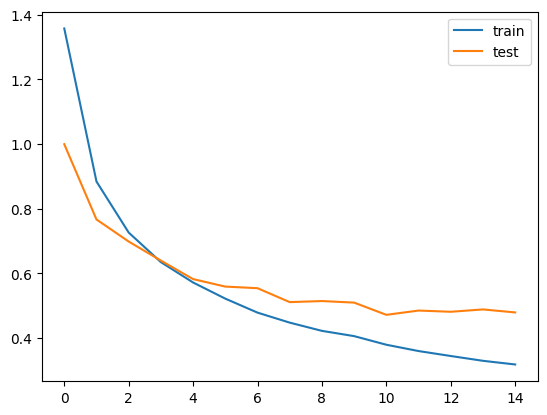

In [ ]:
# loss function plot
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()
plt.show()

In [ ]:
# accuraccy
Imporvedmodel.eval()
with torch.inference_mode():
  n_correct=0
  n_total=0
  for inputs,targets in Train_loader:
    inputs,targets = inputs.to(device),targets.to(device)
    outputs = Imporvedmodel(inputs)
    _,predection = torch.max(outputs,1)
    n_correct+=(predection == targets).sum().item()
    n_total+=targets.shape[0]
  train_acc = n_correct/n_total
print(train_acc)

0.90204


In [ ]:
Imporvedmodel.eval()
with torch.inference_mode():
  n_correct=0
  n_total=0
  for inputs,targets in Test_loader:
    inputs,targets = inputs.to(device),targets.to(device)
    outputs = Imporvedmodel(inputs)
    _,predection = torch.max(outputs,1)
    n_correct+=(predection == targets).sum().item()
    n_total+=targets.shape[0]
  test_acc = n_correct/n_total
print(test_acc)

0.8682


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

[[873   5  44  13   9   2  13  10  22   9]
 [  7 938   2   3   0   0   4   0  10  36]
 [ 27   1 839  23  44  15  34   9   7   1]
 [ 17   0  43 710  50  99  40  26   7   8]
 [  5   1  39  31 868  17  18  19   2   0]
 [  6   0  37  83  23 812  15  20   2   2]
 [  5   0  31  32  15   3 907   2   3   2]
 [  6   0  14  18  28  17   3 906   1   7]
 [ 44  10   8   4   2   2   3   1 919   7]
 [ 17  38   1   5   2   1   3   6  17 910]]


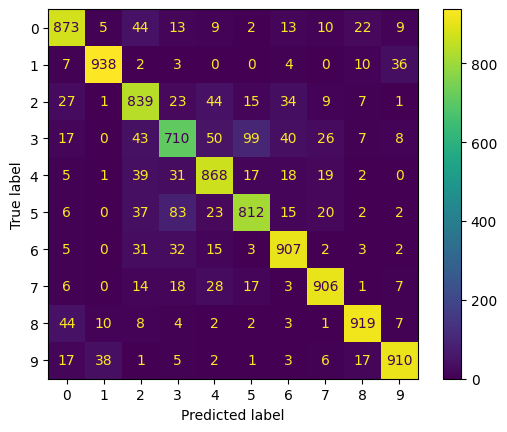

In [ ]:
cm = confusion_matrix(y_test, p_test, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()

print(cm)

In [ ]:
X_test=test_dataset.data
y_test=test_dataset.targets

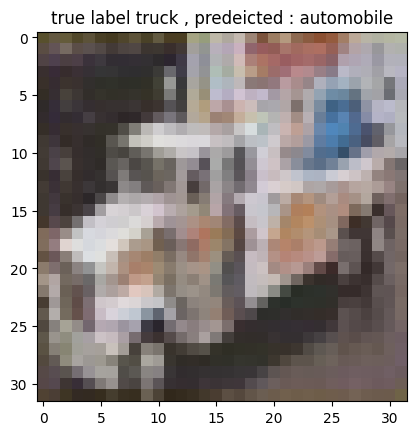

In [ ]:
Labels=train_dataset.classes
x_test = X_test
misMatch=np.where(y_test != p_test)[0]
index=np.random.choice(misMatch)
plt.imshow(x_test[index],cmap='gray')
plt.title(f'true label {Labels[y_test[index]]} , predeicted : {Labels[int(p_test[index])]}')
plt.show()